# How to read multispectral data from POLYPHEME

How to read .spc file from POLYPHEME microscope

```bash
python3 -m pip install pyspectra
```

In [1]:
#testdataspc = '../Examples/data_polypheme_theo/Pos0/Basse_Energie/Basse_Energie.spc'
#testdatatiff = '../Examples/data_polypheme_theo/Pos0/Haute_Enegie_hr/Basse_Energie_hr.tif'
testdataspc = '../Examples/Test_Perles_Polypheme_Cuif/P4_2.spc'
#testdatatiff = '../Examples/Test_Perles_Polypheme_Cuif/P4_2.tif'

In [2]:
import sys
sys.path.append('../')

In [3]:
from src.io.spcread import read_spc
from src.filters.cosmics import despike_hyperspectral

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import stackview

In [5]:
data = read_spc(testdataspc)

x-y(29172)


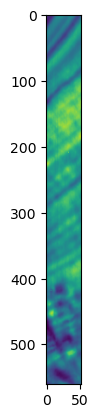

In [6]:
plt.imshow(np.mean(data, 0))

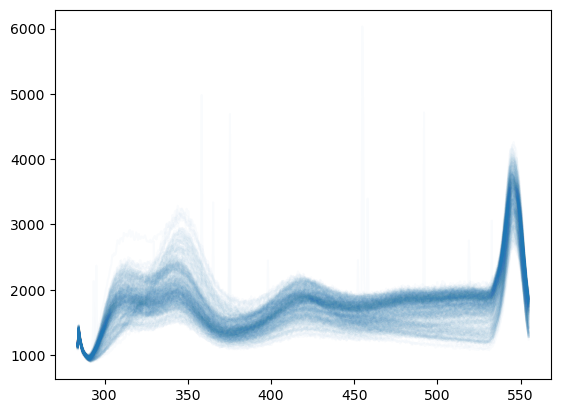

In [7]:
collapsed_xy = data.to_numpy().reshape(data.shape[0], data.shape[1]*data.shape[2])
n_show = int(collapsed_xy.shape[1]/300)
_ = plt.plot(data.w, collapsed_xy[:, ::n_show], color='C0', alpha=0.025)

In [8]:
dd = np.array(data)
stackview.slice(dd.swapaxes(0,2), axis=2, zoom_factor=2)

## Remove spikes and smooth

In [9]:
data_despiked = despike_hyperspectral(data)

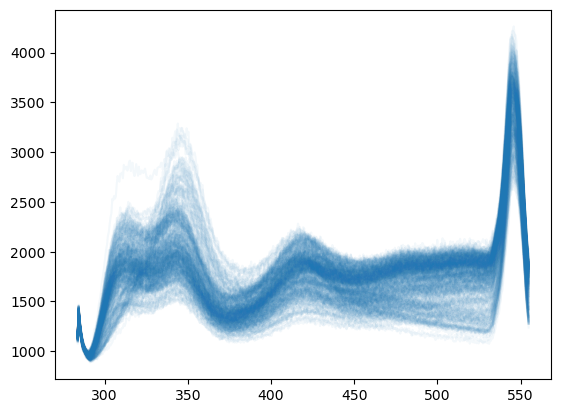

In [10]:
collapsed_xy = data_despiked.reshape(data.shape[0], data.shape[1]*data.shape[2])
_ = plt.plot(data.w, collapsed_xy[:, ::n_show], color='C0', alpha=0.05)

In [11]:
stackview.slice(data_despiked.swapaxes(0,2), axis=2, zoom_factor=2)

## Crop the spectra on on the borders

46 489


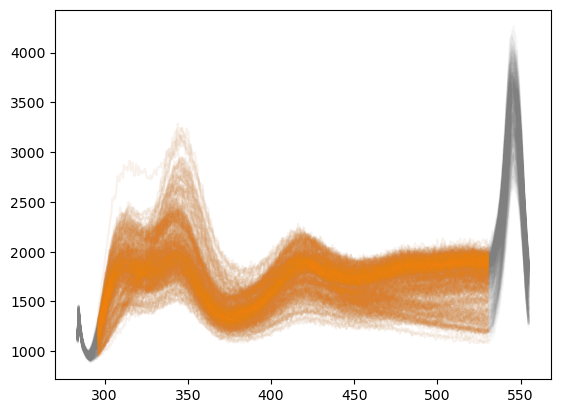

In [12]:
w_inf = 295
w_sup = 530
w = data.w.to_numpy()

try:
    limit_sup = np.argwhere(w > w_inf)[-1][0]
except:
    limit_sup = len(w) - 1
try:
    limit_inf = np.argwhere(w > w_sup)[-1][0]
except:
    linit_inf = 0
    
print(limit_inf, limit_sup)

_ = plt.plot(data.w, collapsed_xy[:, ::n_show], 'gray', alpha=0.05)
_ = plt.plot(data.w[limit_inf:limit_sup], collapsed_xy[limit_inf:limit_sup, ::n_show], 'C1', alpha=0.05)

## PCA Analysis

In [13]:
from sklearn import preprocessing
from sklearn import decomposition

### Pre-processing

Normalisation of the data using 'Norm2' vector normalisation

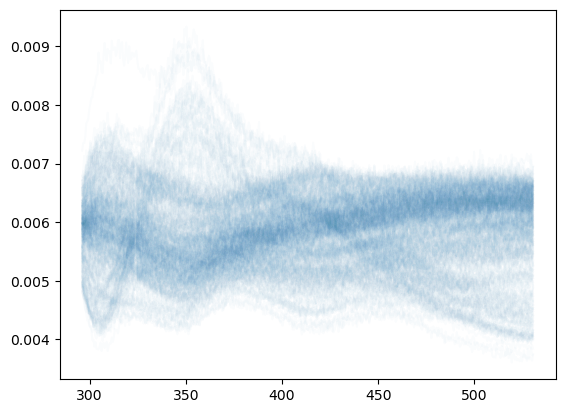

In [14]:
nspectra = preprocessing.normalize(collapsed_xy[limit_inf:limit_sup], axis=1)
_ = plt.plot(data.w[limit_inf:limit_sup], nspectra[:, ::n_show], 'C0', alpha=0.02)

### Remove the mean

In [15]:
Xdata = (nspectra-nspectra.mean(0))

### Do the PCA on 50 components to check

In [16]:
PCA = decomposition.PCA(n_components=50)
model = PCA.fit(Xdata)

Text(0.5, 0, 'PC')

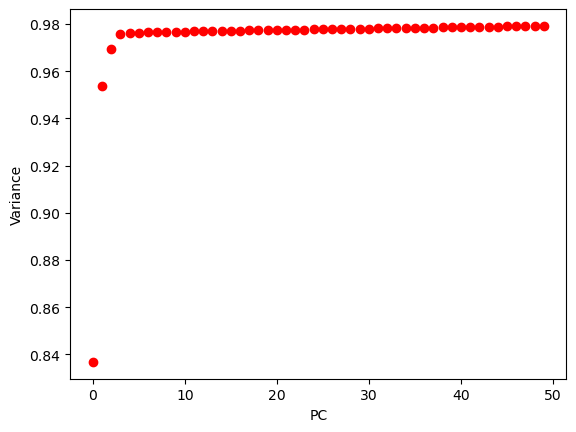

In [17]:
plt.plot(np.cumsum(model.explained_variance_ratio_), 'ro')
plt.ylabel('Variance')
plt.xlabel('PC')

### Re process the data with the selected number of components

In [18]:
PCA = decomposition.PCA(n_components=5)
model = PCA.fit(Xdata)
transformed_data = PCA.transform(Xdata)
Xpca = PCA.inverse_transform(transformed_data)

### Plot usefull info from PCA

Text(0, 0.5, 'PC2')

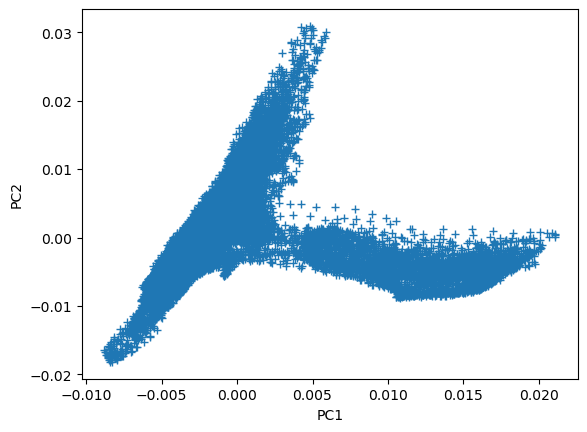

In [19]:
plt.plot(model.components_[0], model.components_[1], '+')
plt.xlabel('PC1')
plt.ylabel('PC2')

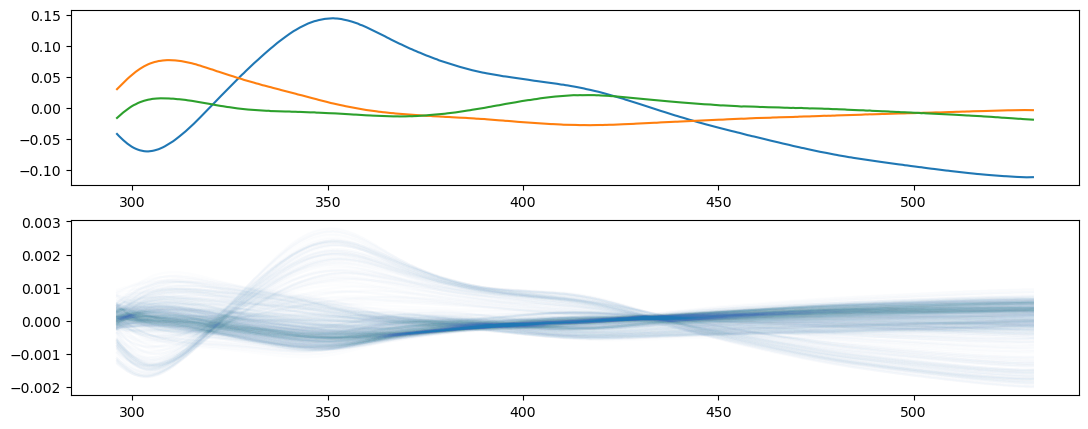

In [20]:
plt.figure(figsize=(13,5))
plt.subplot(211)
_ = plt.plot(data.w[limit_inf:limit_sup], transformed_data[:, :3])
plt.subplot(212)
_ = plt.plot(data.w[limit_inf:limit_sup], (Xpca[:, ::50]), 'C0', alpha=0.01)

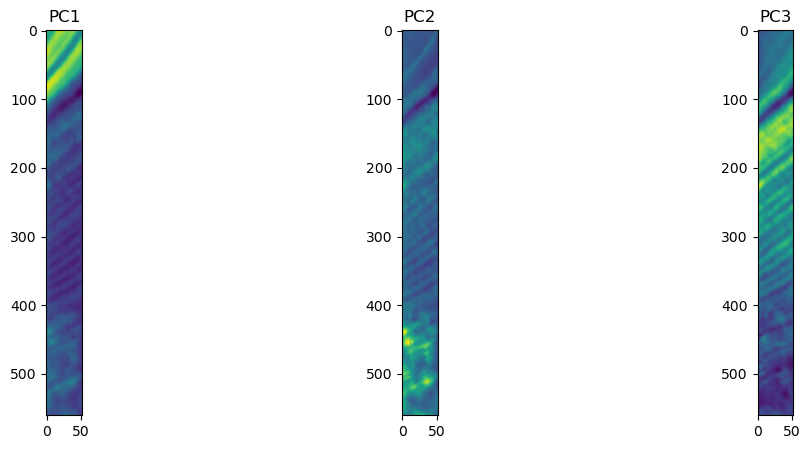

In [21]:
plt.figure(figsize=(13,5))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(model.components_[i].reshape(data.shape[1:]))
    plt.title(f'PC{i+1}')

## Test of interaction with glueviz

In [22]:
import pandas as pd
from glue import qglue
from glue.core import Data, DataCollection
from glue.core.component_link import ComponentLink

testD = pd.DataFrame(model.components_.T, columns=['PC%i'%(i+1) for i in range(model.n_components)])
xx, yy = np.unravel_index(np.array(testD.index), data_despiked.shape[1:])
testD['x'] = xx
testD['y'] = yy

testD2 = pd.DataFrame(transformed_data, columns=['PC%i'%(i+1) for i in range(model.n_components)], 
                      index=data.w.to_numpy()[limit_inf:limit_sup])

link1 = ('PCA.x', 'datacube.Pixel Axis 1 [y]', lambda x: x, lambda x: x)
link2 = ('PCA.y', 'datacube.Pixel Axis 2 [x]', lambda x: x, lambda x: x)
link3 = ('PCA.x', 'PCAmaps.Pixel Axis 1 [y]', lambda x: x, lambda x: x)
link4 = ('PCA.y', 'PCAmaps.Pixel Axis 2 [x]', lambda x: x, lambda x: x)

'''
qglue(datacube=data_despiked, PCA=testD, 
      PCAmaps=model.components_.reshape(model.n_components, 
                                       data_despiked.shape[1], 
                                       data_despiked.shape[2]),
      PCAspectra=testD2,
      links=[link1, link2, link3, link4])

'''

'\nqglue(datacube=data_despiked, PCA=testD, \n      PCAmaps=model.components_.reshape(model.n_components, \n                                       data_despiked.shape[1], \n                                       data_despiked.shape[2]),\n      PCAspectra=testD2,\n      links=[link1, link2, link3, link4])\n\n'

In [23]:
dc = DataCollection()
dc['PCA'] = testD
dc['datacube'] = Data(label='datacube', datacube=data_despiked)

def map_PCA_to_2D_image(pcaX):
    imX, imY = np.unravel_index(pcaX, data_despiked.shape[1:])
    return imX, imY

map_PCA_to_2D_image(dc['PCA']['Pixel Axis 0 [x]'][5000])

(96, 8)

In [24]:
dc['datacube'].components

[Pixel Axis 0 [z], Pixel Axis 1 [y], Pixel Axis 2 [x], datacube]

In [25]:
testD2

PC1       PC2       PC3       PC4       PC5
530.520691 -0.111568 -0.003690 -0.019000 -0.002182 -0.001744
529.992310 -0.111738 -0.003609 -0.018796 -0.002111 -0.001746
529.463928 -0.111734 -0.003471 -0.018702 -0.002609 -0.001560
528.935547 -0.111831 -0.003425 -0.018310 -0.002644 -0.001672
528.407166 -0.111714 -0.003493 -0.018081 -0.002847 -0.001696
...              ...       ...       ...       ...       ...
298.182098 -0.054785  0.043424 -0.004977  0.025508 -0.002138
297.649902 -0.051956  0.040183 -0.007369  0.027485 -0.001700
297.117676 -0.048821  0.036986 -0.010309  0.029417 -0.001147
296.585449 -0.045571  0.033706 -0.013015  0.031399 -0.000559
296.053192 -0.042003  0.030121 -0.016233  0.033398  0.000092

[443 rows x 5 columns]